In [44]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import datasets, model_selection
from sklearn.metrics import log_loss
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
CV_SEED = 2017

train_feature_file = '../build/feature/n1.trn.sps'
test_feature_file = '../build/feature/n1.tst.sps'
n_folds = 5

[train_X, train_y] = datasets.load_svmlight_file(train_feature_file)
[test_X, _] = datasets.load_svmlight_file(test_feature_file)

fold_gen = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=CV_SEED)

In [8]:
cv_folds = list(enumerate(fold_gen.split(train_X)))
k, (dev_ix, val_ix) = cv_folds[0]

dev_X, val_X = train_X[dev_ix, :], train_X[val_ix, :]
dev_y, val_y = train_y[dev_ix], train_y[val_ix]

In [16]:
solver = 'lbfgs'
multi_class = 'multinomial'
max_iter = 100
tol = 0.0001
C = 1.0

model = LogisticRegression(solver=solver, max_iter=max_iter, tol=tol, C=C, random_state=42,
                           multi_class=multi_class)
model.fit(dev_X, dev_y)
pred_val_y = model.predict_proba(val_X)
print solver, multi_class, max_iter, tol, C, log_loss(val_y, pred_val_y)

lbfgs multinomial 100 0.0001 1.0 0.596508798102


In [19]:
solver = 'lbfgs'
multi_class = 'multinomial'
max_iter = 100
tol = 0.0001
C = 1.0

for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag']:
    for multi_class in ['ovr', 'multinomial']:
        if solver == 'liblinear' and multi_class == 'multinomial':
            continue
        model = LogisticRegression(solver=solver, max_iter=max_iter, tol=tol, C=C, random_state=42,
                                   multi_class=multi_class)
        model.fit(dev_X, dev_y)
        pred_trn_y = model.predict_proba(dev_X)
        pred_val_y = model.predict_proba(val_X)

        trn_loss = log_loss(dev_y, pred_trn_y)
        val_loss = log_loss(val_y, pred_val_y)
        print solver, multi_class, max_iter, tol, C, '| Train: %.3f, Valid: %.3f' % (trn_loss, val_loss)

newton-cg ovr 100 0.0001 1.0 | Train: 0.463, Valid: 0.589
newton-cg multinomial 100 0.0001 1.0 | Train: 0.435, Valid: 0.595
lbfgs ovr 100 0.0001 1.0 | Train: 0.480, Valid: 0.592
lbfgs multinomial 100 0.0001 1.0 | Train: 0.495, Valid: 0.597
liblinear ovr 100 0.0001 1.0 | Train: 0.463, Valid: 0.589
sag ovr 100 0.0001 1.0 | Train: 0.463, Valid: 0.589
sag multinomial 100 0.0001 1.0 | Train: 0.436, Valid: 0.595


In [70]:
%%time

solver = 'lbfgs'
multi_class = 'multinomial'
max_iter = 100
tol = 0.0001
C = 1.0

losses = []

for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag']:
    for multi_class in ['ovr', 'multinomial']:
        if solver == 'liblinear' and multi_class == 'multinomial':
            continue
        for C in [2**i for i in range(0, -5, -1)]:            
            model = LogisticRegression(solver=solver, max_iter=max_iter, tol=tol, C=C, random_state=42,
                                       multi_class=multi_class)
            model.fit(dev_X, dev_y)
            pred_trn_y = model.predict_proba(dev_X)
            pred_val_y = model.predict_proba(val_X)

            trn_loss = log_loss(dev_y, pred_trn_y)
            val_loss = log_loss(val_y, pred_val_y)
            losses.append((solver, multi_class, C, 'train', trn_loss))
            losses.append((solver, multi_class, C, 'validation', val_loss))
            print '%s, %s, %s | Train: %.3f, Valid: %.3f' % (solver, multi_class, C, trn_loss, val_loss)


newton-cg, ovr, 1 | Train: 0.463, Valid: 0.589
newton-cg, ovr, 0.5 | Train: 0.490, Valid: 0.585
newton-cg, ovr, 0.25 | Train: 0.519, Valid: 0.588
newton-cg, ovr, 0.125 | Train: 0.548, Valid: 0.596
newton-cg, ovr, 0.0625 | Train: 0.574, Valid: 0.608
newton-cg, multinomial, 1 | Train: 0.435, Valid: 0.595
newton-cg, multinomial, 0.5 | Train: 0.462, Valid: 0.583
newton-cg, multinomial, 0.25 | Train: 0.491, Valid: 0.581
newton-cg, multinomial, 0.125 | Train: 0.520, Valid: 0.585
newton-cg, multinomial, 0.0625 | Train: 0.549, Valid: 0.594
lbfgs, ovr, 1 | Train: 0.480, Valid: 0.592
lbfgs, ovr, 0.5 | Train: 0.496, Valid: 0.586
lbfgs, ovr, 0.25 | Train: 0.520, Valid: 0.588
lbfgs, ovr, 0.125 | Train: 0.548, Valid: 0.596
lbfgs, ovr, 0.0625 | Train: 0.574, Valid: 0.608
lbfgs, multinomial, 1 | Train: 0.495, Valid: 0.597
lbfgs, multinomial, 0.5 | Train: 0.494, Valid: 0.594
lbfgs, multinomial, 0.25 | Train: 0.504, Valid: 0.586
lbfgs, multinomial, 0.125 | Train: 0.525, Valid: 0.587
lbfgs, multinomial, 

In [42]:
loss_df = pd.DataFrame(losses, columns=['solver', 'type', 'C', 'data', 'loss'])

In [43]:
loss_df

,solver,type,C,data,loss
0,newton-cg,ovr,1.0000,train,0.462544
1,newton-cg,ovr,1.0000,validation,0.589357
2,newton-cg,ovr,0.5000,train,0.489991
3,newton-cg,ovr,0.5000,validation,0.584895
4,newton-cg,ovr,0.2500,train,0.518989
5,newton-cg,ovr,0.2500,validation,0.587881
6,newton-cg,ovr,0.1250,train,0.547758
7,newton-cg,ovr,0.1250,validation,0.596355
8,newton-cg,ovr,0.0625,train,0.574266
9,newton-cg,ovr,0.0625,validation,0.607905


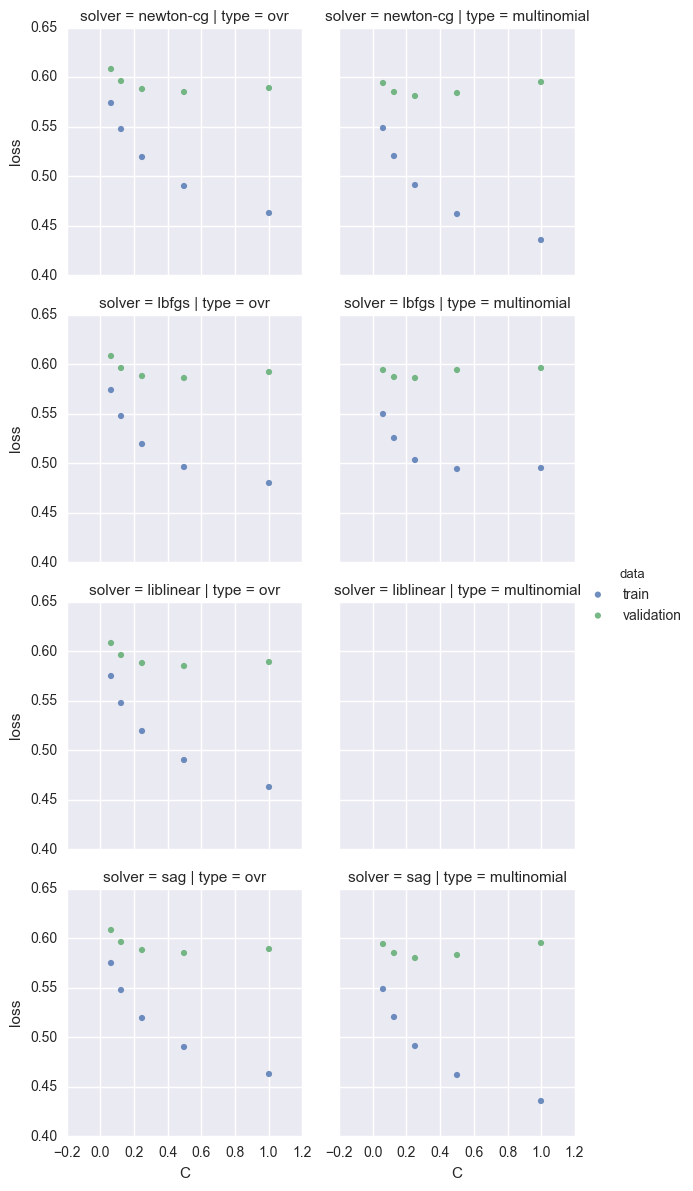

In [59]:
g = sns.lmplot(x="C", y="loss", row="solver", col="type", hue="data",
               fit_reg=False, size=3,data=loss_df)

In [65]:
loss_df[ loss_df['data'] == 'validation' ].sort_values(by='loss')

,solver,type,C,data,loss
65,sag,multinomial,0.2500,validation,0.580507
15,newton-cg,multinomial,0.2500,validation,0.580581
63,sag,multinomial,0.5000,validation,0.583380
13,newton-cg,multinomial,0.5000,validation,0.583437
67,sag,multinomial,0.1250,validation,0.584866
43,liblinear,ovr,0.5000,validation,0.584876
3,newton-cg,ovr,0.5000,validation,0.584895
53,sag,ovr,0.5000,validation,0.584916
17,newton-cg,multinomial,0.1250,validation,0.584934
35,lbfgs,multinomial,0.2500,validation,0.585773


In [69]:
%%time

solver = 'lbfgs'
multi_class = 'multinomial'
max_iter = 100
tol = 0.0001
C = 1.0

losses_warm = []

for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag']:
    for multi_class in ['ovr', 'multinomial']:
        if solver == 'liblinear' and multi_class == 'multinomial':
            continue
        for C in [2**i for i in range(0, -5, -1)]:
            model = LogisticRegression(solver=solver, max_iter=max_iter, tol=tol, C=C, random_state=42,
                                       multi_class=multi_class, warm_start=True)
            model.fit(dev_X, dev_y)
            pred_trn_y = model.predict_proba(dev_X)
            pred_val_y = model.predict_proba(val_X)

            trn_loss = log_loss(dev_y, pred_trn_y)
            val_loss = log_loss(val_y, pred_val_y)
            losses_warm.append((solver, multi_class, C, 'train', trn_loss))
            losses_warm.append((solver, multi_class, C, 'validation', val_loss))
            print '%s, %s, %s | Train: %.3f, Valid: %.3f' % (solver, multi_class, C, trn_loss, val_loss)


newton-cg, ovr, 1 | Train: 0.463, Valid: 0.589
newton-cg, ovr, 0.5 | Train: 0.490, Valid: 0.585
newton-cg, ovr, 0.25 | Train: 0.519, Valid: 0.588
newton-cg, ovr, 0.125 | Train: 0.548, Valid: 0.596
newton-cg, ovr, 0.0625 | Train: 0.574, Valid: 0.608
newton-cg, multinomial, 1 | Train: 0.435, Valid: 0.595
newton-cg, multinomial, 0.5 | Train: 0.462, Valid: 0.583
newton-cg, multinomial, 0.25 | Train: 0.491, Valid: 0.581
newton-cg, multinomial, 0.125 | Train: 0.520, Valid: 0.585
newton-cg, multinomial, 0.0625 | Train: 0.549, Valid: 0.594
lbfgs, ovr, 1 | Train: 0.480, Valid: 0.592
lbfgs, ovr, 0.5 | Train: 0.496, Valid: 0.586
lbfgs, ovr, 0.25 | Train: 0.520, Valid: 0.588
lbfgs, ovr, 0.125 | Train: 0.548, Valid: 0.596
lbfgs, ovr, 0.0625 | Train: 0.574, Valid: 0.608
lbfgs, multinomial, 1 | Train: 0.495, Valid: 0.597
lbfgs, multinomial, 0.5 | Train: 0.494, Valid: 0.594
lbfgs, multinomial, 0.25 | Train: 0.504, Valid: 0.586
lbfgs, multinomial, 0.125 | Train: 0.525, Valid: 0.587
lbfgs, multinomial, 

In [86]:
mean_wts = np.mean(np.abs(model.coef_), axis=0)
names = [ str(i) for i in range(0, mean_wts.shape[0]) ]
zip(mean_wts, names)[:5]

[(0.10127643058094217, '0'),
 (0.4314715048116689, '1'),
 (0.41295742552944087, '2'),
 (0.41295742552944087, '3'),
 (0.046662973890568456, '4')]

In [113]:
names = []
for line in open('../build/feature/n1.fmap'):
    ix, name, _ = line.split('\t')
    names.append(name)

In [114]:
feat_imp = zip(names, mean_wts)
feat_imp_sorted = sorted(feat_imp, key=lambda x: x[0], reverse=True)
feat_df = pd.DataFrame(feat_imp, columns=['feature', 'score'])
feat_df = feat_df.sort_values(by='score', ascending=False)
feat_df.head()

,feature,score
4598,ohe4587,0.710899
8200,tag_furnished,0.678353
3387,ohe3376,0.582657
2770,ohe2759,0.579555
2004,ohe1993,0.560212


In [115]:
feat_df.to_csv('test.csv', index=False)

In [116]:
!head test.csv

feature,score
ohe4587,0.710898960071
tag_furnished,0.678352726936
ohe3376,0.582656713723
ohe2759,0.579555428396
ohe1993,0.560211693345
ohe3231,0.547225265927
ohe2512,0.534847209977
ohe8098,0.523921093899
ohe2601,0.485762208185


In [78]:
abs(model.coef_).shape

(3, 8331)

In [112]:
!head ../build/feature/n1.fmap


0	bathrooms	q
1	bedrooms	q
2	price	q
3	log_price	q
4	num_photos	q
5	num_features	q
6	log_num_features	q
7	has_long_feature	q
8	has_all_caps_feature	q
9	num_description_words	q


In [119]:
np.savetxt('train_y.txt', train_y, fmt='%d')

In [121]:
!tail train_y.txt

2
0
0
0
1
1
0
0
0
0


In [124]:
pd.Series(train_y, name='interest_level').to_csv('train_y.csv', index=False, header=True)

In [125]:
!head train_y.csv

interest_level
1.0
0.0
2.0
0.0
0.0
1.0
0.0
0.0
1.0


In [139]:
print cv_folds[0][1][0].shape
print cv_folds[0][1][1].shape

(39481,)
(9871,)


In [140]:
# Fine-tune the regularization

In [143]:
[2**(i/2.0) for i in range(0, -10, -1)]

[1.0,
 0.7071067811865476,
 0.5,
 0.3535533905932738,
 0.25,
 0.1767766952966369,
 0.125,
 0.08838834764831845,
 0.0625,
 0.04419417382415922]

In [144]:
%%time

solver = 'sag'
multi_class = 'multinomial'
max_iter = 100
tol = 0.0001
C = 1.0

for C in [2**(i/2.0) for i in range(0, -10, -1)]:
    model = LogisticRegression(solver=solver, max_iter=max_iter, tol=tol, C=C, random_state=42,
                               multi_class=multi_class, warm_start=True)
    model.fit(dev_X, dev_y)
    pred_trn_y = model.predict_proba(dev_X)
    pred_val_y = model.predict_proba(val_X)

    trn_loss = log_loss(dev_y, pred_trn_y)
    val_loss = log_loss(val_y, pred_val_y)

    print '%s, %s, %s | Train: %.3f, Valid: %.3f' % (solver, multi_class, C, trn_loss, val_loss)


sag, multinomial, 1.0 | Train: 0.436, Valid: 0.595
sag, multinomial, 0.707106781187 | Train: 0.448, Valid: 0.588
sag, multinomial, 0.5 | Train: 0.462, Valid: 0.583
sag, multinomial, 0.353553390593 | Train: 0.476, Valid: 0.581
sag, multinomial, 0.25 | Train: 0.491, Valid: 0.581
sag, multinomial, 0.176776695297 | Train: 0.506, Valid: 0.582
sag, multinomial, 0.125 | Train: 0.520, Valid: 0.585
sag, multinomial, 0.0883883476483 | Train: 0.535, Valid: 0.589
sag, multinomial, 0.0625 | Train: 0.549, Valid: 0.594
sag, multinomial, 0.0441941738242 | Train: 0.562, Valid: 0.600
CPU times: user 1min 5s, sys: 776 ms, total: 1min 6s
Wall time: 1min 29s
